In [1]:
# Train on a custom dataset
# https://detectron2.readthedocs.io/tutorials/datasets.html

# Run following commands
# python run_trainer.py
# tensorboard --logdir output

import os
import cv2
import json
import random
import numpy as np
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog


def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), 
                         np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, 
                            lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")


## Verify the correctness of the dataset

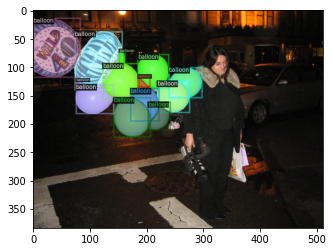

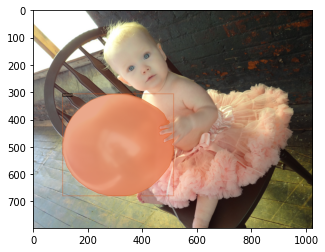

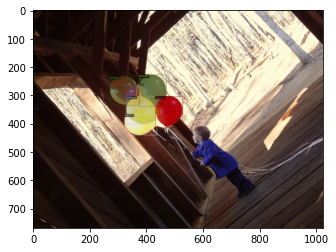

In [2]:
# Verify the data loading is correct
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image())
    plt.show()

## Finetune on the custom dataset

In [3]:
# Fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset.
# Take ~3 minutes to train 300 iterations

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

# Let training initialize from model zoo
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
#    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") 
cfg.MODEL.WEIGHTS = "mask_rcnn_R_50_FPN_3x_model_final_f10217.pkl"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR

# 300 iterations seems good enough for this toy dataset; 
# you may need to train longer for a practical dataset
cfg.SOLVER.MAX_ITER = 300    

# faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
# only has one class (ballon)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/08 11:34:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[04/08 11:34:14 d2.engine.train_loop]: Starting training from iteration 0
[04/08 11:34:23 d2.utils.events]:  eta: 0:02:05  iter: 19  total_loss: 2.069  loss_cls: 0.684  loss_box_reg: 0.626  loss_mask: 0.697  loss_rpn_cls: 0.043  loss_rpn_loc: 0.006  time: 0.4428  data_time: 0.0199  lr: 0.000005  max_mem: 2551M
[04/08 11:34:32 d2.utils.events]:  eta: 0:01:53  iter: 39  total_loss: 1.930  loss_cls: 0.638  loss_box_reg: 0.572  loss_mask: 0.666  loss_rpn_cls: 0.029  loss_rpn_loc: 0.009  time: 0.4424  data_time: 0.0083  lr: 0.000010  max_mem: 2672M
[04/08 11:34:41 d2.utils.events]:  eta: 0:01:46  iter: 59  total_loss: 1.913  loss_cls: 0.591  loss_box_reg: 0.627  loss_mask: 0.618  loss_rpn_cls: 0.035  loss_rpn_loc: 0.009  time: 0.4465  data_time: 0.0077  lr: 0.000015  max_mem: 2672M
[04/08 11:34:50 d2.utils.events]:  eta: 0:01:38  iter: 79  total_loss: 1.790  loss_cls: 0.523  loss_box_reg: 0.682  loss_mask: 0.539  loss_rpn_cls: 0.040  loss_rpn_loc: 0.009  time: 0.4508  data_time: 0.0078  lr:

In [4]:
cfg.MODEL.WEIGHTS

'mask_rcnn_R_50_FPN_3x_model_final_f10217.pkl'

In [5]:
!tensorboard --logdir output

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0a20190928 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# Inference & evaluation using the trained model

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

# set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

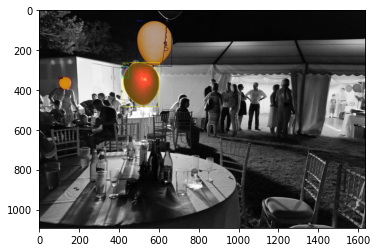

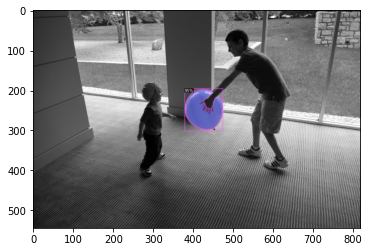

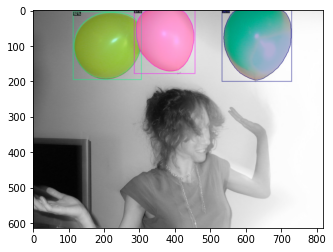

In [8]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8,
                   # remove the colors of unsegmented pixels 
                   instance_mode=ColorMode.IMAGE_BW   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show();

### Evaluate with AP metric implemented in COCO API
This gives an AP of ~70%. Not bad!

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")

val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

# another equivalent way is to use trainer.test

WARNING [04/08 11:40:44 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'balloon_val'. Trying to convert it to COCO format ...
[04/08 11:40:44 d2.data.datasets.coco]: Cached annotations in COCO format already exist: ./output/balloon_val_coco_format.json
[04/08 11:40:45 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[04/08 11:40:45 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[04/08 11:40:45 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/08 11:40:45 d2.evaluation.evaluator]: Start inference on 13 images
[04/08 11:40:51 d2.evaluation.evaluator]: Inference done 11/13. 0.1332 s / img. ETA=0:00:00
[04/08 11:40:52 d2.evaluation.evaluator]: Total inference time: 0:00:02.356716 (0.294590 s / img per device, on 1 devices)
[04/08 11:40:52 d2.evaluation.evaluator]: Total inferenc

OrderedDict([('bbox',
              {'AP': 68.9487125187314,
               'AP50': 86.22436928209221,
               'AP75': 81.5170415079255,
               'APs': 22.72277227722772,
               'APm': 57.505923348079754,
               'APl': 81.47401013818208}),
             ('segm',
              {'AP': 78.62426448448043,
               'AP50': 85.83108296842731,
               'AP75': 85.24188324685187,
               'APs': 13.201245463912906,
               'APm': 60.01974328670051,
               'APl': 94.78635931333986})])